In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../CDOM_DATA/TURB/Trub_cal_6.14.23/*.txt')
filescdom = '../../../CDOM_DATA/TURB/Turb_2317_6.14.23/*.txt'

#here is where the output will go 
path2 = '../../../TURB/Final/Turb_cal_6.14.csv'
path3 = '../../../TURB/Final/Turb_CU_rerun_2317.csv'
plot1 = "../../../TURB/Final/Color_Curve_abs_455_rerun_2317.png"
plot2 = "../../../TURB/Final/Color_Curve_abs_412_rerun_2317.png"
spct = '../../../TURB/Final/Spectra_rerun_2317.csv'
files

['../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\005_cu_Absorbance__0__00.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\010_cu_Absorbance__0__01.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\015_cu_Absorbance__0__02.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\020_cu_Absorbance__0__03.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\025_cu_Absorbance__0__04.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\030_cu_Absorbance__0__05.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\040_cu_Absorbance__0__06.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\050_cu_Absorbance__0__07.txt',
 '../../../CDOM_DATA/TURB/Trub_cal_6.14.23\\100_cu_Absorbance__0__08.txt']

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,005_cu_Absorbance__0__00.txt,010_cu_Absorbance__0__01.txt,015_cu_Absorbance__0__02.txt,020_cu_Absorbance__0__03.txt,025_cu_Absorbance__0__04.txt,030_cu_Absorbance__0__05.txt,040_cu_Absorbance__0__06.txt,050_cu_Absorbance__0__07.txt,100_cu_Absorbance__0__08.txt,wl
wl,,,,,,,,,,
189,-0.001713,-0.001811,-0.002984,0.274904,-0.294230,-0.000162,-0.127910,0.000429,0.431553,189
190,-0.001713,-0.001811,-0.002984,0.274904,-0.294230,-0.000162,-0.127910,0.000429,0.431553,190
191,0.592122,1.982681,0.444566,-0.094675,0.131027,-0.042528,0.161381,-0.030122,-0.044737,191
192,-0.626511,1.092452,-0.002984,0.070336,-0.001030,-0.000162,0.000890,0.000429,0.000553,192
193,-0.001713,-0.223442,0.145938,-0.261666,0.019897,-0.057718,-0.001490,0.000429,-0.519598,193
...,...,...,...,...,...,...,...,...,...,...
876,0.006766,0.006198,0.003093,0.000575,-0.000053,0.003379,0.002414,-0.001618,0.000915,876
877,0.000489,0.003009,0.004873,-0.005610,-0.003827,0.001131,0.001849,0.003835,0.002729,877
878,0.003267,-0.003387,-0.002830,0.000980,0.001421,-0.003555,-0.004574,-0.003558,0.000798,878


In [5]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=8).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,005,010,015,020,025,030,040,050,100,wl
wl,,,,,,,,,,
189,-0.001713,-0.001811,-0.002984,0.274904,-0.294230,-0.000162,-0.127910,0.000429,0.431553,189
190,-0.001713,-0.001811,-0.002984,0.274904,-0.294230,-0.000162,-0.127910,0.000429,0.431553,190
191,0.592122,1.982681,0.444566,-0.094675,0.131027,-0.042528,0.161381,-0.030122,-0.044737,191
192,-0.626511,1.092452,-0.002984,0.070336,-0.001030,-0.000162,0.000890,0.000429,0.000553,192
193,-0.001713,-0.223442,0.145938,-0.261666,0.019897,-0.057718,-0.001490,0.000429,-0.519598,193
...,...,...,...,...,...,...,...,...,...,...
876,0.006766,0.006198,0.003093,0.000575,-0.000053,0.003379,0.002414,-0.001618,0.000915,876
877,0.000489,0.003009,0.004873,-0.005610,-0.003827,0.001131,0.001849,0.003835,0.002729,877
878,0.003267,-0.003387,-0.002830,0.000980,0.001421,-0.003555,-0.004574,-0.003558,0.000798,878


Text(0.5, 1.0, 'color curve 1 CM')

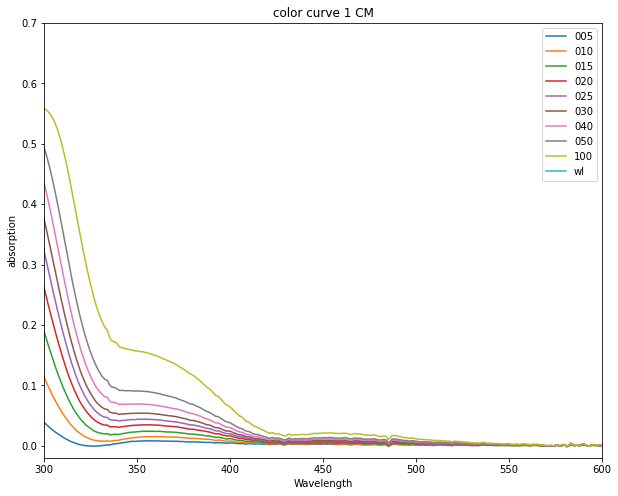

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.02,.7)
ax.set_xlim(300,600)
ax.set_xlabel("Wavelength")
ax.set_ylabel("absorption")
ax.set_title("color curve 1 CM")

#plt.savefig("../../../TURB/PTCO_2309.png")

In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_455 = df[(df['wl']==455)][col].mean()
    abs_412 = df[(df['wl']==412)][col].mean()
    
    dict = {'sample':[columnName],
        'abs_455':[abs_455],
            'abs_412':[abs_412],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs
conc = ss_outs
conc['CU'] = conc.index.astype(int)

#row = pd.DataFrame([0] * len(conc.columns), columns=conc.columns)
#conc = conc.append(row, ignore_index=True)

conc = conc.sort_values('CU')
conc

,abs_455,abs_412,CU
sample,,,
005,0.002233,0.002771,5
010,0.003145,0.004117,10
015,0.004055,0.006008,15
020,0.006104,0.008789,20
025,0.007198,0.010711,25
030,0.008666,0.012994,30
040,0.010850,0.016103,40
050,0.012974,0.020343,50
100,0.020874,0.034088,100


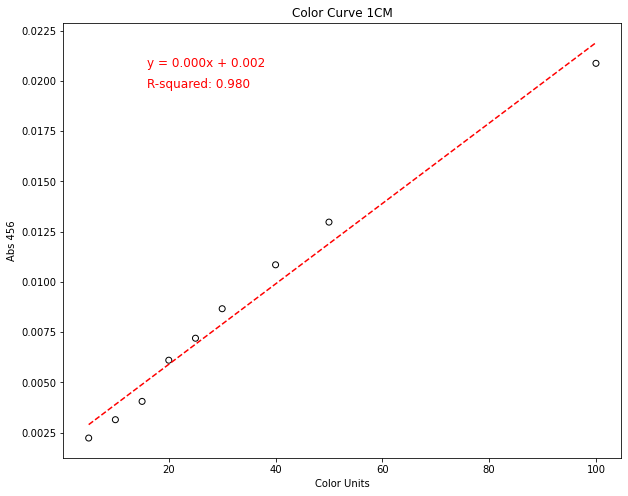

In [8]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc['CU'], conc['abs_455'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc['CU']
y = conc['abs_455']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 456')
ax.set_title('Color Curve 1CM')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


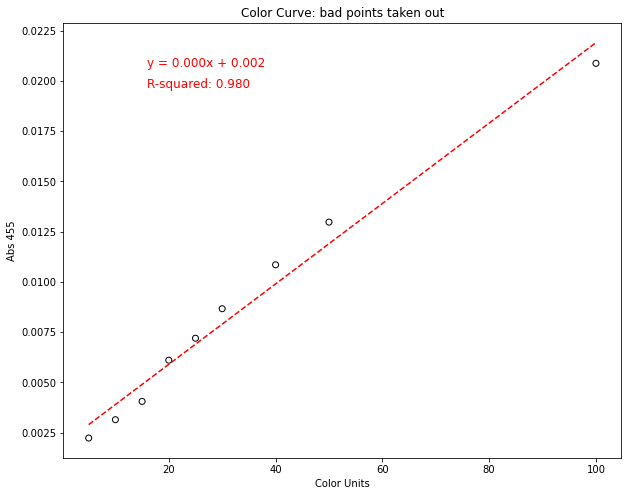

In [9]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

conc_clean = conc.loc[conc["CU"] != 80]
#conc_clean = conc_clean.loc[conc_clean["CU"] != 30]


ax.scatter(conc_clean["CU"], conc_clean['abs_455'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean["CU"]
y = conc_clean['abs_455']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 455')
ax.set_title('Color Curve: bad points taken out')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

#plt.savefig("../../../TURB/PTCO_abs_456_2309.png")

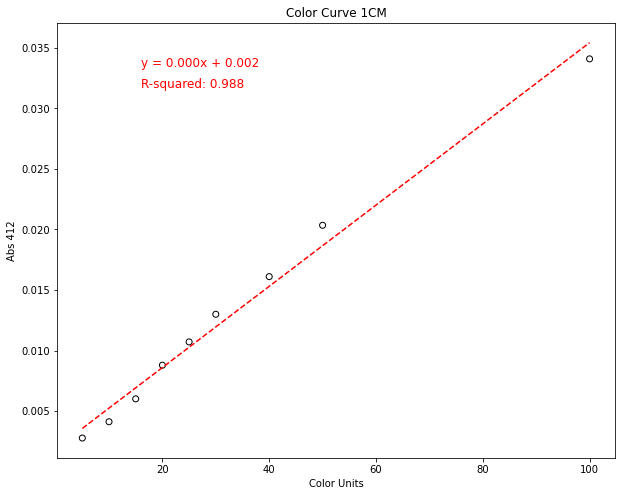

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc['CU'], conc['abs_412'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc['CU']
y = conc['abs_412']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 412')
ax.set_title('Color Curve 1CM')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


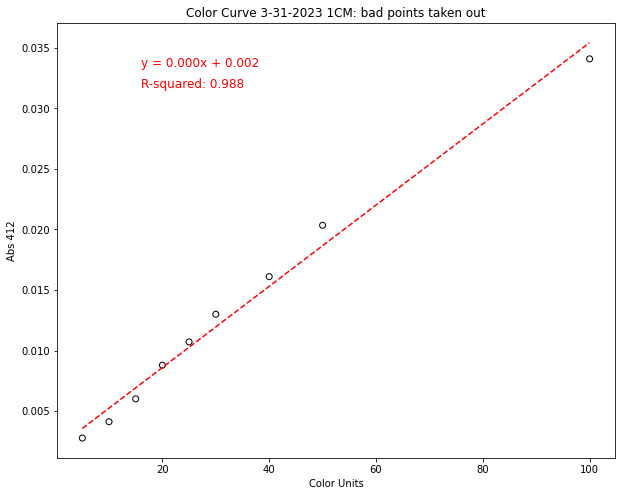

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc_clean['CU'], conc_clean['abs_412'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['CU']
y = conc_clean['abs_412']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 412')
ax.set_title('Color Curve 3-31-2023 1CM: bad points taken out')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

#plt.savefig("../../../TURB/PTCO_abs_412_2309.png")

In [12]:
files2 = glob.glob(filescdom)

frames = []
for f in files2:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,231701_Absorbance__0__09.txt,231702_Absorbance__0__11.txt,231703_Absorbance__0__30.txt,231704_Absorbance__0__10.txt,231705_Absorbance__0__29.txt,231706_Absorbance__0__28.txt,231707_Absorbance__0__27.txt,231708_Absorbance__0__26.txt,231709_Absorbance__0__25.txt,231710_Absorbance__0__14.txt,...,231713_Absorbance__0__13.txt,231714_Absorbance__0__23.txt,231715_Absorbance__0__12.txt,231716_Absorbance__0__21.txt,231717_Absorbance__0__15.txt,231718_Absorbance__0__17.txt,231719_Absorbance__0__18.txt,231720_Absorbance__0__22.txt,231721_Absorbance__0__20.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,0.999842,0.560506,-0.222497,-0.464178,-0.320870,-0.397195,-0.257566,-0.497707,-0.401175,-0.256619,...,-0.168589,-0.357653,-0.073900,-0.420806,-0.384350,-0.244871,-0.622949,-0.314929,-0.329146,189
190,0.999842,0.560506,-0.222497,-0.464178,-0.320870,-0.397195,-0.257566,-0.497707,-0.401175,-0.256619,...,-0.168589,-0.357653,-0.073900,-0.420806,-0.384350,-0.244871,-0.622949,-0.314929,-0.329146,190
191,0.071760,0.109055,-0.435517,-0.341094,-0.081799,-0.323921,-0.182876,-0.194595,-0.087790,-0.174983,...,0.101376,-0.061190,-0.134626,-0.393654,-0.006179,-0.209691,0.312327,0.014866,-0.196387,191
192,0.001042,0.002006,-0.001797,0.001922,-0.001170,-0.001595,-0.001066,0.002093,0.004325,0.003281,...,0.002611,0.005447,0.005700,0.004294,0.003450,0.003929,0.003151,0.001871,0.001854,192
193,-0.046870,-0.141597,-0.481943,-0.055563,-0.086616,-0.054200,-0.053983,-0.055826,-0.067140,-0.012558,...,-0.106818,-0.049138,-0.056022,-0.082819,-0.021700,0.145292,-0.066925,-0.058045,-0.036909,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.000505,-0.006391,-0.008534,-0.003517,-0.010917,-0.011486,-0.017642,-0.012658,-0.011142,-0.008870,...,-0.011401,-0.006730,-0.008024,-0.004333,-0.010568,-0.011784,-0.014711,-0.006283,-0.000938,876
877,-0.001980,-0.007998,-0.015963,-0.004837,-0.013841,-0.018916,-0.014269,-0.013202,-0.012620,-0.007908,...,-0.013664,-0.014524,-0.011262,-0.006158,-0.012277,-0.010324,-0.010215,-0.013318,-0.008497,877
878,-0.007919,-0.013913,-0.016160,-0.012244,-0.014352,-0.015601,-0.019243,-0.021714,-0.020379,-0.013195,...,-0.018679,-0.021344,-0.014511,-0.016559,-0.013651,-0.015094,-0.018152,-0.017055,-0.008720,878


In [13]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=8).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index

dft = df.T
dft.to_csv(spct, index=True)

df

,231701,231702,231703,231704,231705,231706,231707,231708,231709,231710,...,231713,231714,231715,231716,231717,231718,231719,231720,231721,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,0.999842,0.560506,-0.222497,-0.464178,-0.320870,-0.397195,-0.257566,-0.497707,-0.401175,-0.256619,...,-0.168589,-0.357653,-0.073900,-0.420806,-0.384350,-0.244871,-0.622949,-0.314929,-0.329146,189
190,0.999842,0.560506,-0.222497,-0.464178,-0.320870,-0.397195,-0.257566,-0.497707,-0.401175,-0.256619,...,-0.168589,-0.357653,-0.073900,-0.420806,-0.384350,-0.244871,-0.622949,-0.314929,-0.329146,190
191,0.071760,0.109055,-0.435517,-0.341094,-0.081799,-0.323921,-0.182876,-0.194595,-0.087790,-0.174983,...,0.101376,-0.061190,-0.134626,-0.393654,-0.006179,-0.209691,0.312327,0.014866,-0.196387,191
192,0.001042,0.002006,-0.001797,0.001922,-0.001170,-0.001595,-0.001066,0.002093,0.004325,0.003281,...,0.002611,0.005447,0.005700,0.004294,0.003450,0.003929,0.003151,0.001871,0.001854,192
193,-0.046870,-0.141597,-0.481943,-0.055563,-0.086616,-0.054200,-0.053983,-0.055826,-0.067140,-0.012558,...,-0.106818,-0.049138,-0.056022,-0.082819,-0.021700,0.145292,-0.066925,-0.058045,-0.036909,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.000505,-0.006391,-0.008534,-0.003517,-0.010917,-0.011486,-0.017642,-0.012658,-0.011142,-0.008870,...,-0.011401,-0.006730,-0.008024,-0.004333,-0.010568,-0.011784,-0.014711,-0.006283,-0.000938,876
877,-0.001980,-0.007998,-0.015963,-0.004837,-0.013841,-0.018916,-0.014269,-0.013202,-0.012620,-0.007908,...,-0.013664,-0.014524,-0.011262,-0.006158,-0.012277,-0.010324,-0.010215,-0.013318,-0.008497,877
878,-0.007919,-0.013913,-0.016160,-0.012244,-0.014352,-0.015601,-0.019243,-0.021714,-0.020379,-0.013195,...,-0.018679,-0.021344,-0.014511,-0.016559,-0.013651,-0.015094,-0.018152,-0.017055,-0.008720,878


Text(0.5, 1.0, 'Samples: 1 CM')

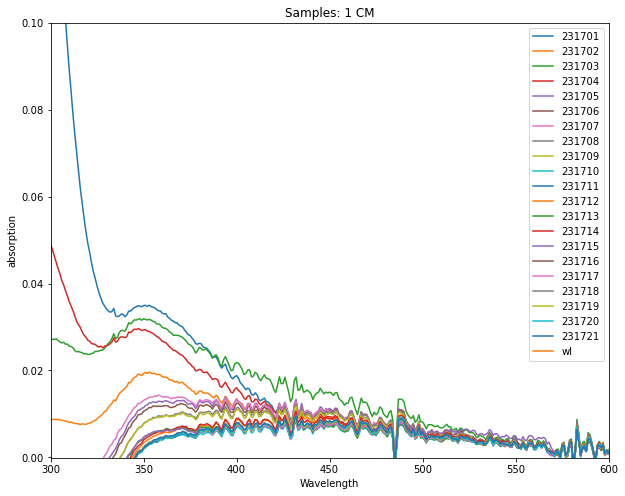

In [14]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.0001,.1)
ax.set_xlim(300,600)
ax.set_xlabel("Wavelength")
ax.set_ylabel("absorption")
ax.set_title("Samples: 1 CM")

#plt.savefig("../../../TURB/Spectra_2309.png")

In [15]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_455 = df[(df['wl']==455)][col].mean()
    abs_412 = df[(df['wl']==412)][col].mean()
    
    dict = {'sample':[columnName],
        'abs_455':[abs_455],
            'abs_412':[abs_412],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

ss_outs

,abs_455,abs_412
sample,,
231701,0.009700,0.013269
231702,0.008218,0.011006
231703,0.013544,0.018170
231704,0.008444,0.012503
231705,0.010095,0.011096
231706,0.009919,0.010250
231707,0.009844,0.011230
231708,0.009673,0.009877
231709,0.009327,0.009353


In [16]:
x = conc_clean['abs_455']
y = conc_clean['CU']
coefficients456 = np.polyfit(x, y, 1)
slope456 = coefficients456[0]
int456 = coefficients456[1]

x = conc_clean['abs_412']
y = conc_clean['CU']
coefficients412 = np.polyfit(x, y, 1)
slope412 = coefficients412[0]
int412 = coefficients412[1]

In [17]:
ss_outs['CU_412'] = (ss_outs['abs_412']*slope412)+int412
ss_outs['CU_455'] = (ss_outs['abs_455']*slope456)+int456

ss_outs.to_csv(path3)

ss_outs

,abs_455,abs_412,CU_412,CU_455
sample,,,,
231701,0.009700,0.013269,33.921150,38.874448
231702,0.008218,0.011006,27.256033,31.612895
231703,0.013544,0.018170,48.356666,57.700729
231704,0.008444,0.012503,31.666139,32.719362
231705,0.010095,0.011096,27.520658,40.810548
231706,0.009919,0.010250,25.031290,39.946380
231707,0.009844,0.011230,27.917392,39.578828
231708,0.009673,0.009877,23.930341,38.742793
231709,0.009327,0.009353,22.389342,37.044436


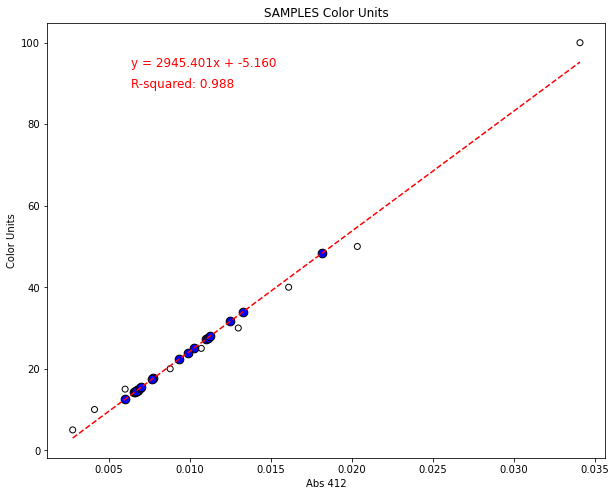

In [18]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['abs_412'], ss_outs['CU_412'], facecolor='blue', edgecolor='black', s = 75)
ax.scatter(conc_clean['abs_412'], conc_clean['CU'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['abs_412']
y = conc_clean['CU']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_ylabel('Color Units')
ax.set_xlabel('Abs 412')
ax.set_title('SAMPLES Color Units')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

fig.set_facecolor('w')

plt.savefig(plot2)
# show plot
plt.show()

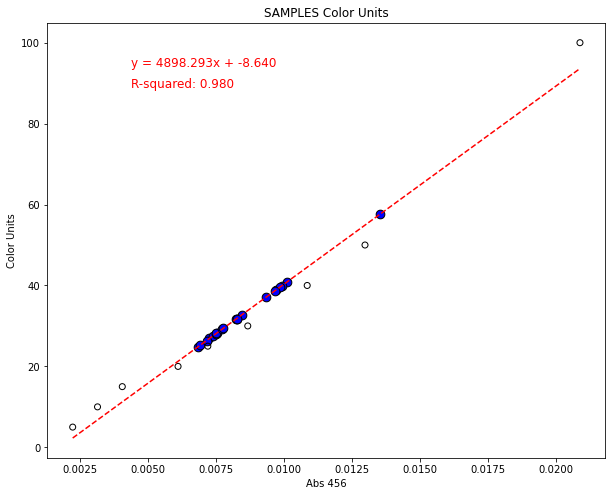

In [19]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['abs_455'], ss_outs['CU_455'], facecolor='blue', edgecolor='black', s = 75)
ax.scatter(conc_clean['abs_455'], conc_clean['CU'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['abs_455']
y = conc_clean['CU']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_ylabel('Color Units')
ax.set_xlabel('Abs 456')
ax.set_title('SAMPLES Color Units')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

fig.set_facecolor('w')

plt.savefig(plot1)
# show plot
plt.show()
